# 3.1.4 Convergence Rates


## Convergence Rate Analysis of SOEN Models

The convergence rates of SOEN models were investigated under varying gamma ($\gamma$) and tau ($\tau$) parameters. The study aimed to explore how the mean and distribution of these parameters affect the model's ability to reach equilibrium and the rate at which it does so.

### Base SOEN Model Specifications

| Category | Parameters |
|----------|------------|
| Network Structure | **Nodes:** 10 (fully connected)<br>**Input type:** Flux |
| Activation | **Function:** Gaussian mixture |
| Convergence | **Equilibrium tolerance:** $$1 \times 10^{-6}$$<br>**Maximum iterations:** 10,000 |
| Simulation | **$$\Delta t$$:** 0.05 |
| Initialisation | **Bias flux offsets:** Enabled<br>**$$J$$ Normal initialisation method with standard deviation:** 0.1 |

### Grid Searches

Two grid searches were conducted:

1. **Gamma Grid Search:** $\gamma_{\text{mean}}$ and $\gamma_{\text{std}}$ were varied, with $\tau_{\text{mean}} = 1$ and $\tau_{\text{std}} = 0.1$.
2. **Tau Grid Search:** $\tau_{\text{mean}}$ and $\tau_{\text{std}}$ were varied, with $\gamma_{\text{mean}} = 1$ and $\gamma_{\text{std}} = 0.1$.

### Convergence Rate Computation

The convergence rate for each grid point was computed as follows:

1. New model created (since models are created stochastically each model will have different weights).
2. A random input signal was sampled from a uniform distribution between 0 and 1.
3. The model's forward pass was executed and the state evolution was recorded.
4. The number of time steps to reach equilibrium was determined.
5. Steps 2-4 were repeated 10 times, with the minimum convergence time taken. The minimum and not mean was taken to avoid erroneous rates caused by instabilities in the network affecting results.

The results of this experiment can be found in Section 4.1.4 of the report

In [1]:
import sys,os
os.chdir(os.path.dirname(os.path.abspath("./"))) # only run this once
print(os.getcwd())

/Users/matthewcox/Documents/UCL/MSc/Full_Phen_SOEN


In [8]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from model.soen_model import SOENModel
from utils.soen_model_utils import *
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator

**Experiment Number 1:** Convergence Rate w.r.t Network Size

This study does not appear in the report, but nonetheless reveals interesting findings about the stability of networks when using different activation functions. 

- Stability does not appear to be an issue for learning however, because trained models comprising $>1000$ nodes reach equilibrium very quickly. Sometimes in under 100 timesteps. The trained models I am referring to are the MNIST models. The have 784 input node, 1000 hidden nodes, and 10 output nodes. 

Quick test to simply run a forward pass and plot state evolution

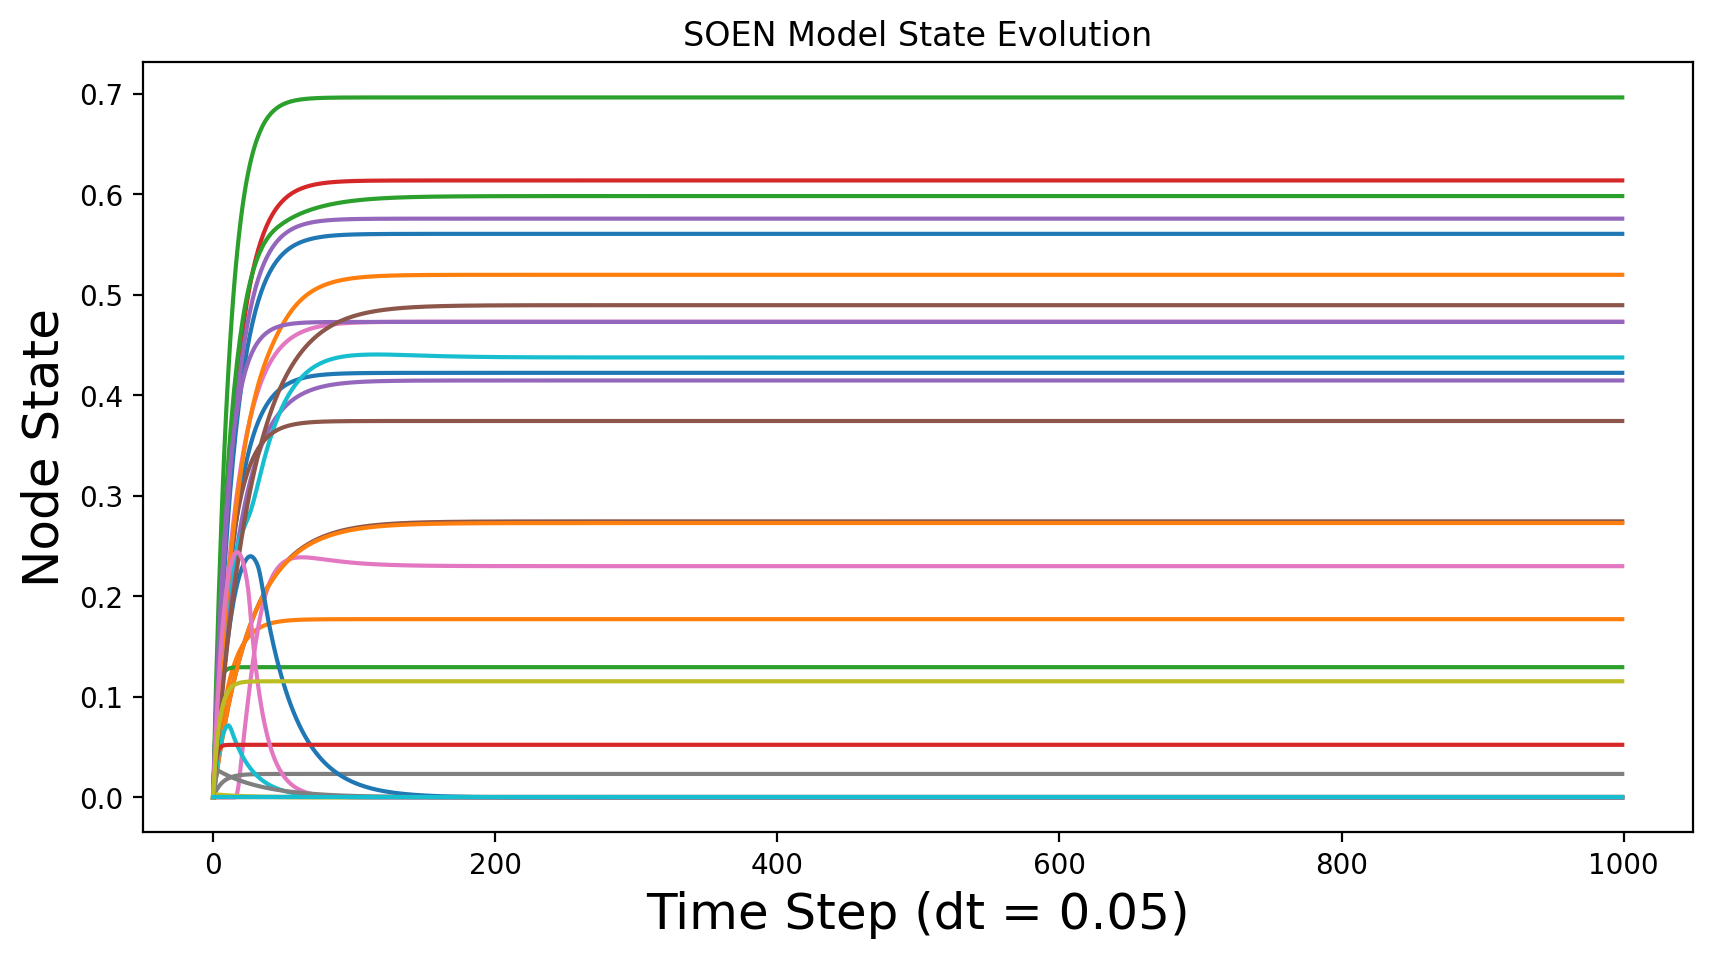

In [3]:

def run_soen_simulation():
    # Create a configuration
    config = SOENConfig()
    config.num_input = 30
    config.num_hidden = 0
    config.num_output = 0
    config.input_type = 'flux'
    config.track_state_evolution = True
    config.bias_flux_offsets = True
    config.max_iter = 10_00
    config.dt = 0.05
    config.activation_function = 'NN_dendrite'

    # Create the model
    model = SOENModel(config)

    # Create an input signal
    input_signal = torch.randn(1, config.num_input)

    # Run the simulation
    model.eval()
    with torch.no_grad():
        output = model(input_signal)

    # Get the state evolution
    state_evolution = np.array(model.state_evolution)

    # Plot the state evolution
    plot_state_evolution(state_evolution, config, "SOEN Model State Evolution")

def plot_state_evolution(state_evolution, config, title):
    plt.figure(figsize=(10, 5), dpi=200)
    num_nodes = state_evolution.shape[2]
    for node_index in range(num_nodes):
        plt.plot(state_evolution[:, 0, node_index], label=f"Node {node_index}")
    plt.xlabel(f"Time Step (dt = {config.dt})", fontsize=18)
    plt.ylabel("Node State", fontsize=18)
    plt.title(title)
    plt.show()


run_soen_simulation()

In [4]:

class SOENExperiment:
    def __init__(self, config):
        self.config = config
        self.model = SOENModel(config)
        self.state_evolution = None
        self.time_steps_to_equilibrium = 0

    def run_single_pass(self, input_signal):
        self.model.eval()
        with torch.no_grad():
            output = self.model(input_signal)
        self.state_evolution = np.array(self.model.state_evolution)
        self.time_steps_to_equilibrium = self.state_evolution.shape[0]
        return output

    def plot_state_evolution(self, node_indices, title, label_prefix, show_legend=True):
        plt.figure(figsize=(10, 5), dpi=200)
        for node_index in node_indices:
            plt.plot(self.state_evolution[:, 0, node_index], label=f"{label_prefix} Node {node_index}")
        plt.xlabel(f"Time Step ($dt = {self.config.dt}$)", fontsize=18)
        plt.ylabel(f"{label_prefix} Node State", fontsize=18)
        if show_legend:
            plt.legend(fontsize=12)
        plt.title(title)
        plt.show()

def run_experiments(num_input_nodes_list, activation_function, num_runs=10):
    convergence_rates = []
    for num_input_nodes in tqdm(num_input_nodes_list, desc="Running experiments", unit="net"):
        config = SOENConfig(
            num_input=num_input_nodes,
            num_hidden=0,
            num_output=0,
            input_type='flux',
            p_input_input=1,
            p_hidden_hidden=1,
            p_output_output=1,
            p_input_hidden=1,
            p_hidden_output=1,
            allow_skip_connections=False,
            track_state_evolution=True,
            run_to_equilibrium=True,
            bias_flux_offsets=True,
            tol=1e-6,
            max_iter=10_000,
            dt=0.05,
            init_scale=0.1,
            gamma_mean=1,
            gamma_std=0.1,
            tau_mean=1,
            tau_std=0.1,
            activation_function=activation_function,
            test_noise_std=0.0
        )
        
        run_times = []
        for _ in tqdm(range(num_runs), desc=f"Input Nodes: {num_input_nodes}", leave=False, unit="run"):
            input_signal = torch.ones(1, num_input_nodes)  # Set flux input to ones
            experiment = SOENExperiment(config)
            experiment.run_single_pass(input_signal)
            run_times.append(experiment.time_steps_to_equilibrium)

        convergence_rates.append((np.mean(run_times), np.std(run_times)))

    return convergence_rates

def plot_convergence_rates(network_sizes, convergence_rates):
    mean_convergence, std_convergence = zip(*convergence_rates)

    plt.figure(figsize=(10, 5), dpi=200)
    plt.plot(network_sizes, mean_convergence, color='black', linewidth=2, label="Mean Time Steps to Equilibrium")
    plt.fill_between(network_sizes, 
                     np.array(mean_convergence) - np.array(std_convergence), 
                     np.array(mean_convergence) + np.array(std_convergence), 
                     color='red', alpha=0.2, edgecolor='black', linewidth=0.5, label="Standard Deviation")

    plt.xlabel('Network Size (Number of Input Nodes)', fontsize=16)
    plt.ylabel('Time Steps to Equilibrium', fontsize=16)
    plt.grid(alpha=0.3)
    plt.xlim(min(network_sizes), max(network_sizes))
    plt.ylim(0, max(np.array(mean_convergence) + np.array(std_convergence)))
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(fontsize=12)
    plt.show()

Running experiments: 100%|██████████| 30/30 [00:03<00:00,  9.79net/s]


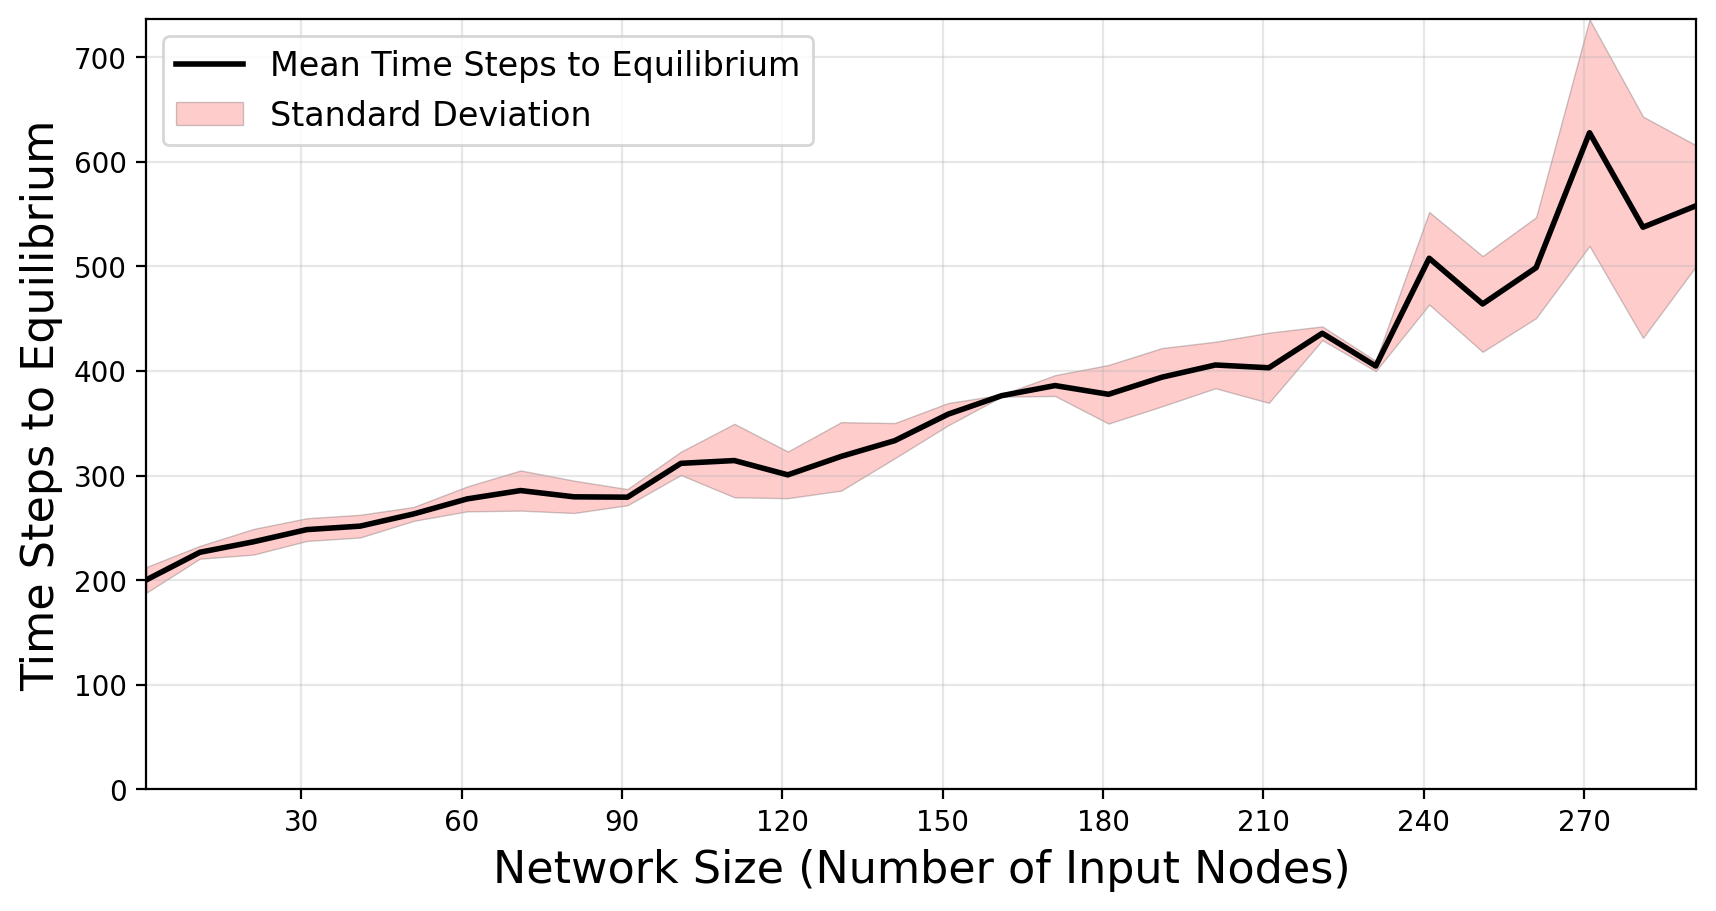

In [9]:
# Tanh-1d
num_input_nodes_list = list(range(1, 300, 10))
activation_function = 'tanh_1d'  # You can change this to any desired activation function

convergence_rates = run_experiments(num_input_nodes_list, activation_function, num_runs=3)
plot_convergence_rates(num_input_nodes_list, convergence_rates)

Running experiments: 100%|██████████| 30/30 [00:04<00:00,  6.86net/s]


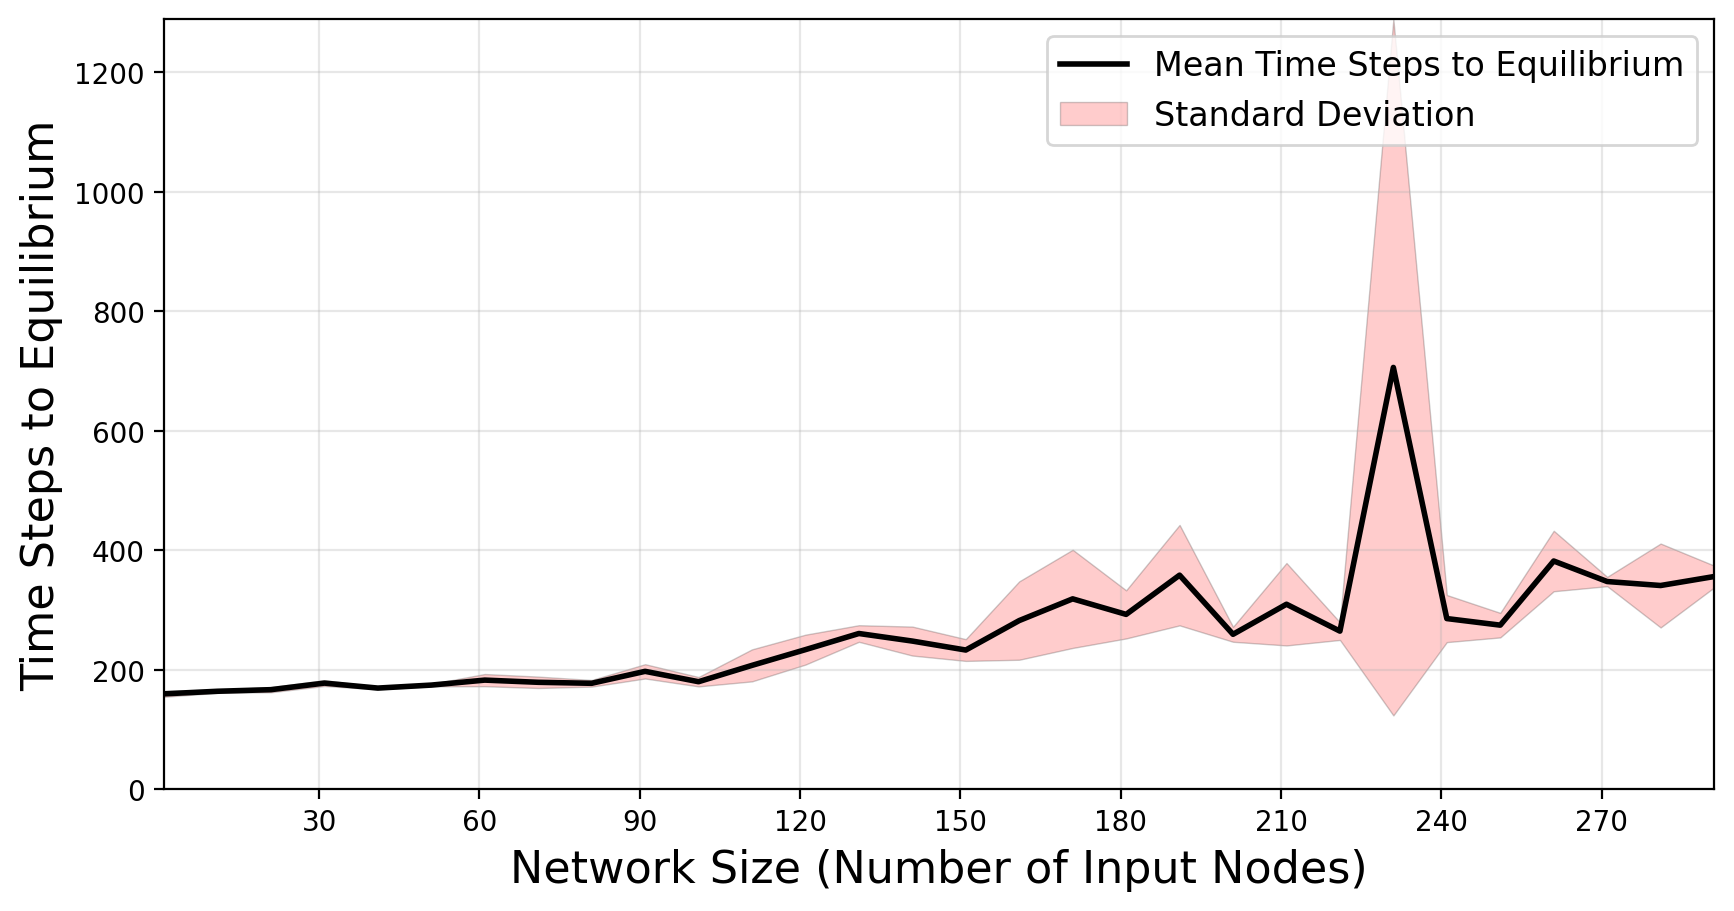

In [10]:
# NN-Dendrite
activation_function = 'NN_dendrite'

convergence_rates = run_experiments(num_input_nodes_list, activation_function, num_runs=3)
plot_convergence_rates(num_input_nodes_list, convergence_rates)

Running experiments: 100%|██████████| 30/30 [00:03<00:00,  8.01net/s]


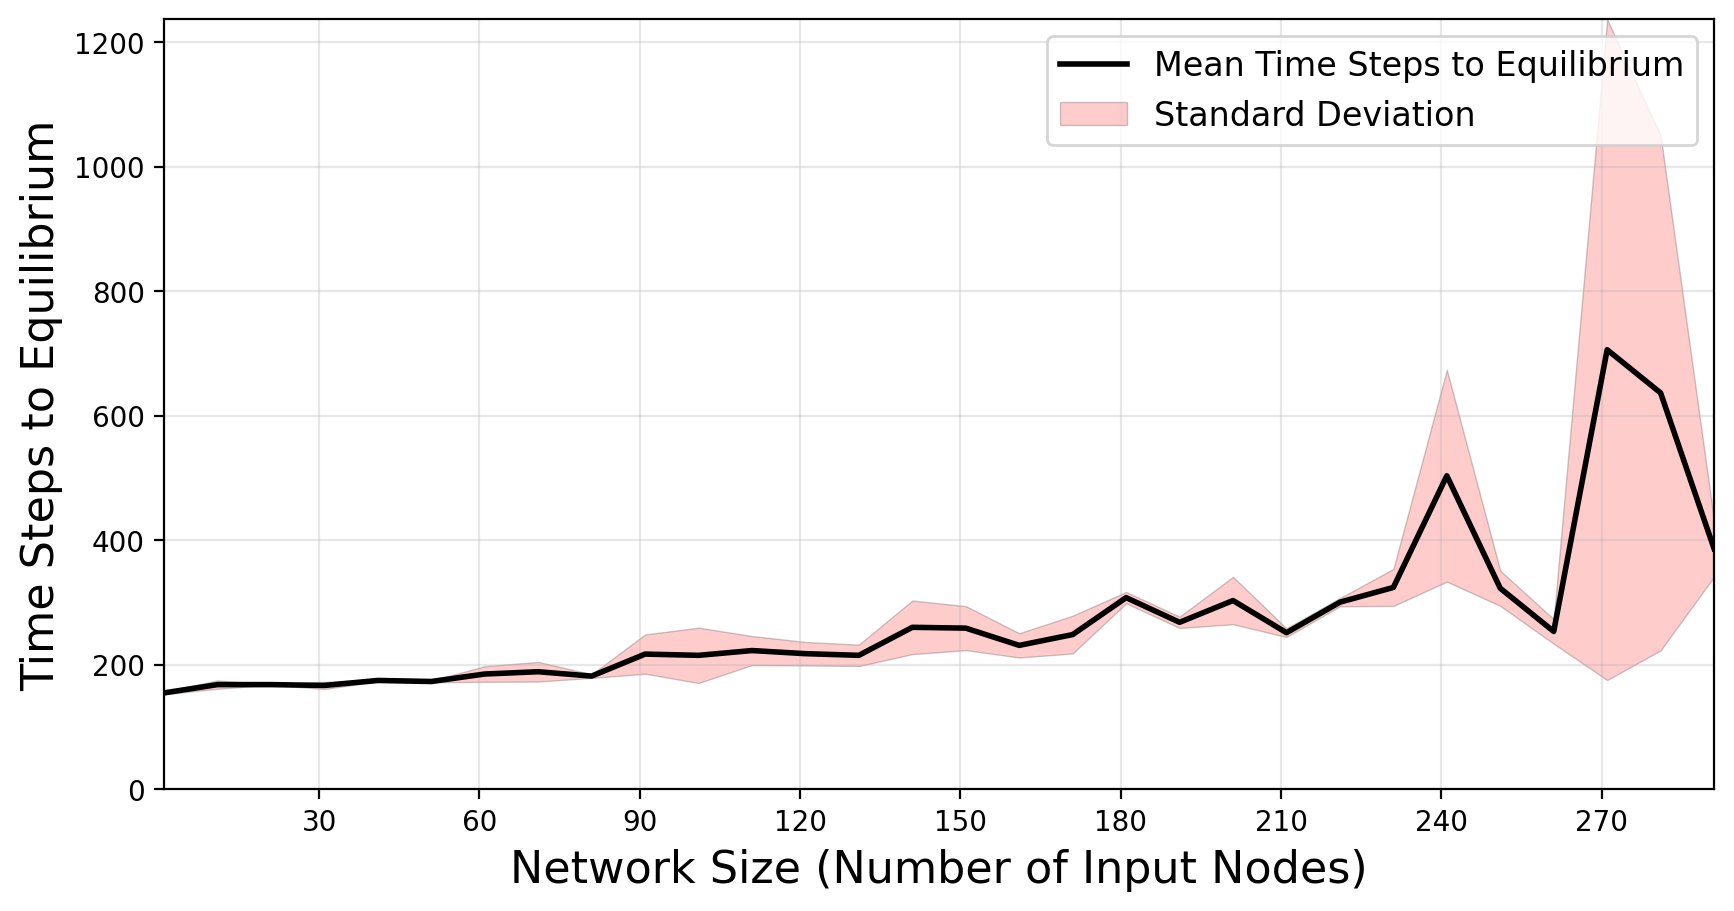

In [49]:
# Gaussian Mixture
activation_function = 'gaussian_mixture'

convergence_rates = run_experiments(num_input_nodes_list, activation_function, num_runs=3)
plot_convergence_rates(num_input_nodes_list, convergence_rates)

Continuing with experiment 1

In [11]:
def create_original_config():
    # Create the configuration object
    config = SOENConfig()

    # Set the configuration parameters
    config.num_input = 10
    config.num_hidden = 0
    config.num_output = 0

    config.p_input_input = 1
    config.p_hidden_hidden = 1
    config.p_output_output = 1

    config.p_input_hidden = 1
    config.p_hidden_output = 1

    config.allow_skip_connections = False
    config.p_skip_connections = 1
    config.input_type = "flux"

    config.track_state_evolution = True
    config.run_to_equilibrium = True
    config.tol = 1e-6
    config.max_iter = 10_000
    config.dt = 0.01
    config.test_noise_std = 0
    config.bias_flux_offsets = True

    config.activation_function = 'gaussian_mixture'  # options are 'gaussian_mixture','sigmoid_mixture','relu','tanh',"NN_dendrite"

    return config

In [67]:
from tqdm import tqdm
import numpy as np
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import math

########################################
#       Convergence Rate Function      #
########################################

def compute_convergence_rate(model, num_runs=3):
    convergence_rate = []
    for _ in range(num_runs):
        input_signal = torch.ones(1, model.num_input)
        with torch.no_grad():
            output = model(input_signal)

        state_evolution = np.array(model.state_evolution)  # shape (number of time steps in pass, 1, number of nodes)
        time_steps_take_to_reach_equilibrium = state_evolution.shape[0]
        convergence_rate.append(time_steps_take_to_reach_equilibrium)
    return np.min(convergence_rate), np.std(convergence_rate)


def create_config_variant(original_config, gamma_mean, gamma_std, tau_mean, tau_std):
    new_config = deepcopy(original_config)
    new_config.gamma_mean = gamma_mean
    new_config.gamma_std = gamma_std
    new_config.tau_mean = tau_mean
    new_config.tau_std = tau_std
    return new_config


########################################
#       Gamma and Tau Experiments      #
########################################

def run_grid_search(original_config, param_type, param_mean_values, param_std_values, gamma_mean=1, gamma_std=0.1, tau_mean=1, tau_std=0.1, num_runs=3):
    """
    Run grid search over either gamma or tau values.
    
    :param param_type: 'gamma' or 'tau'
    :param param_mean_values: list of mean values for the parameter
    :param param_std_values: list of std values for the parameter
    :param gamma_mean: gamma mean for tau experiments
    :param gamma_std: gamma std for tau experiments
    :param tau_mean: tau mean for gamma experiments
    :param tau_std: tau std for gamma experiments
    :param num_runs: number of runs for each grid point
    """
    res = len(param_mean_values)
    convergence_rates = np.zeros((res, res))

    print(f"Performing grid search for convergence rates over {param_type} values")
    for i, param_mean in enumerate(tqdm(param_mean_values, desc=f"{param_type.capitalize()} Mean")):
        for j, param_std in enumerate(tqdm(param_std_values, desc=f"{param_type.capitalize()} Std", leave=False)):
            if param_type == 'gamma':
                config = create_config_variant(original_config, param_mean, param_std, tau_mean, tau_std)
            else:
                config = create_config_variant(original_config, gamma_mean, gamma_std, param_mean, param_std)
            
            model = SOENModel(config).eval()
            convergence_rate = compute_convergence_rate(model, num_runs=num_runs)
            mean_rate, std_rate = convergence_rate
            convergence_rates[i, j] = mean_rate

    return convergence_rates






########################################
#            Plotting Heatmaps         #
########################################

def plot_heatmaps(convergence_rates_gamma, convergence_rates_tau, gamma_mean_values, gamma_std_values, tau_mean_values, tau_std_values):
    sns.set(style='white')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=200, sharey=True)

    # log scale the convergence rates to visualize the differences
    log_convergence_rates_gamma = np.log(convergence_rates_gamma + 1) 
    log_convergence_rates_tau = np.log(convergence_rates_tau + 1)

    # Gamma heatmap
    gamma_heatmap = sns.heatmap(log_convergence_rates_gamma, ax=ax1, cmap='viridis', 
                                cbar_kws={'label': 'Log(Time Steps to Equilibrium)', 'use_gridspec': False, 'location': 'right'},
                                square=True)
    ax1.set_xlabel('Gamma Std', fontsize=20)
    ax1.set_ylabel('Gamma Mean', fontsize=20) 

    ax1.invert_yaxis() 
    ax1.set_yticks(np.arange(len(gamma_mean_values)))
    ax1.set_yticklabels([f'{val:.2f}' for val in gamma_mean_values], fontsize=16)
    ax1.set_xticks(np.arange(len(gamma_std_values)))
    ax1.set_xticklabels([f'{val:.2f}' for val in gamma_std_values], rotation=45, fontsize=16)
    ax1.set_title("(a)", fontsize=18)

    cbar1 = gamma_heatmap.collections[0].colorbar
    cbar1.ax.tick_params(labelsize=16)  
    cbar1.set_label('$\log$(Time Steps to Equilibrium)', fontsize=20)
    cbar1.set_ticks(cbar1.get_ticks())
    cbar1.set_ticklabels([f'{x:.1f}' for x in cbar1.get_ticks()])

    # Tau heatmap
    tau_heatmap = sns.heatmap(log_convergence_rates_tau, ax=ax2, cmap='viridis', 
                              cbar_kws={'label': 'Log(Time Steps to Equilibrium)', 'use_gridspec': False, 'location': 'right'},
                              square=True)
    ax2.set_xlabel('Tau Std', fontsize=20)
    ax2.set_ylabel('Tau Mean', fontsize=20)

    ax2.invert_yaxis()
    ax2.set_yticks(np.arange(len(tau_mean_values)))  
    ax2.set_yticklabels([f'{val:.1f}' for val in tau_mean_values], fontsize=16)  

    ax2.set_xticks(np.arange(len(tau_std_values)))
    ax2.set_xticklabels([f'{val:.1f}' for val in tau_std_values], rotation=45, fontsize=16)
    ax2.set_title("(b)", fontsize=18)

    cbar2 = tau_heatmap.collections[0].colorbar
    cbar2.ax.tick_params(labelsize=16)  
    cbar2.set_label('$\log$(Time Steps to Equilibrium)', fontsize=20)
    cbar2.set_ticks(cbar2.get_ticks())
    cbar2.set_ticklabels([f'{x:.1f}' for x in cbar2.get_ticks()])

    # plt.tight_layout()
    plt.show()

In [75]:

########################################
#            Running Experiments       #
########################################


original_config = create_original_config()

# define the parameter grids
res = 20
gamma_mean_values = np.linspace(0.1, 10, res)
gamma_std_values = np.linspace(0, 2, res)
tau_mean_values = np.linspace(0.1, 10, res)
tau_std_values = np.linspace(0, 2, res)

# run grid searches for both Gamma and Tau
convergence_rates_gamma = run_grid_search(original_config, 'gamma', gamma_mean_values, gamma_std_values, num_runs=3)
convergence_rates_tau = run_grid_search(original_config, 'tau', tau_mean_values, tau_std_values, num_runs=3)

Performing grid search for convergence rates over gamma values


Gamma Mean: 100%|██████████| 20/20 [01:08<00:00,  3.42s/it]


Performing grid search for convergence rates over tau values


Tau Mean: 100%|██████████| 20/20 [03:14<00:00,  9.70s/it]


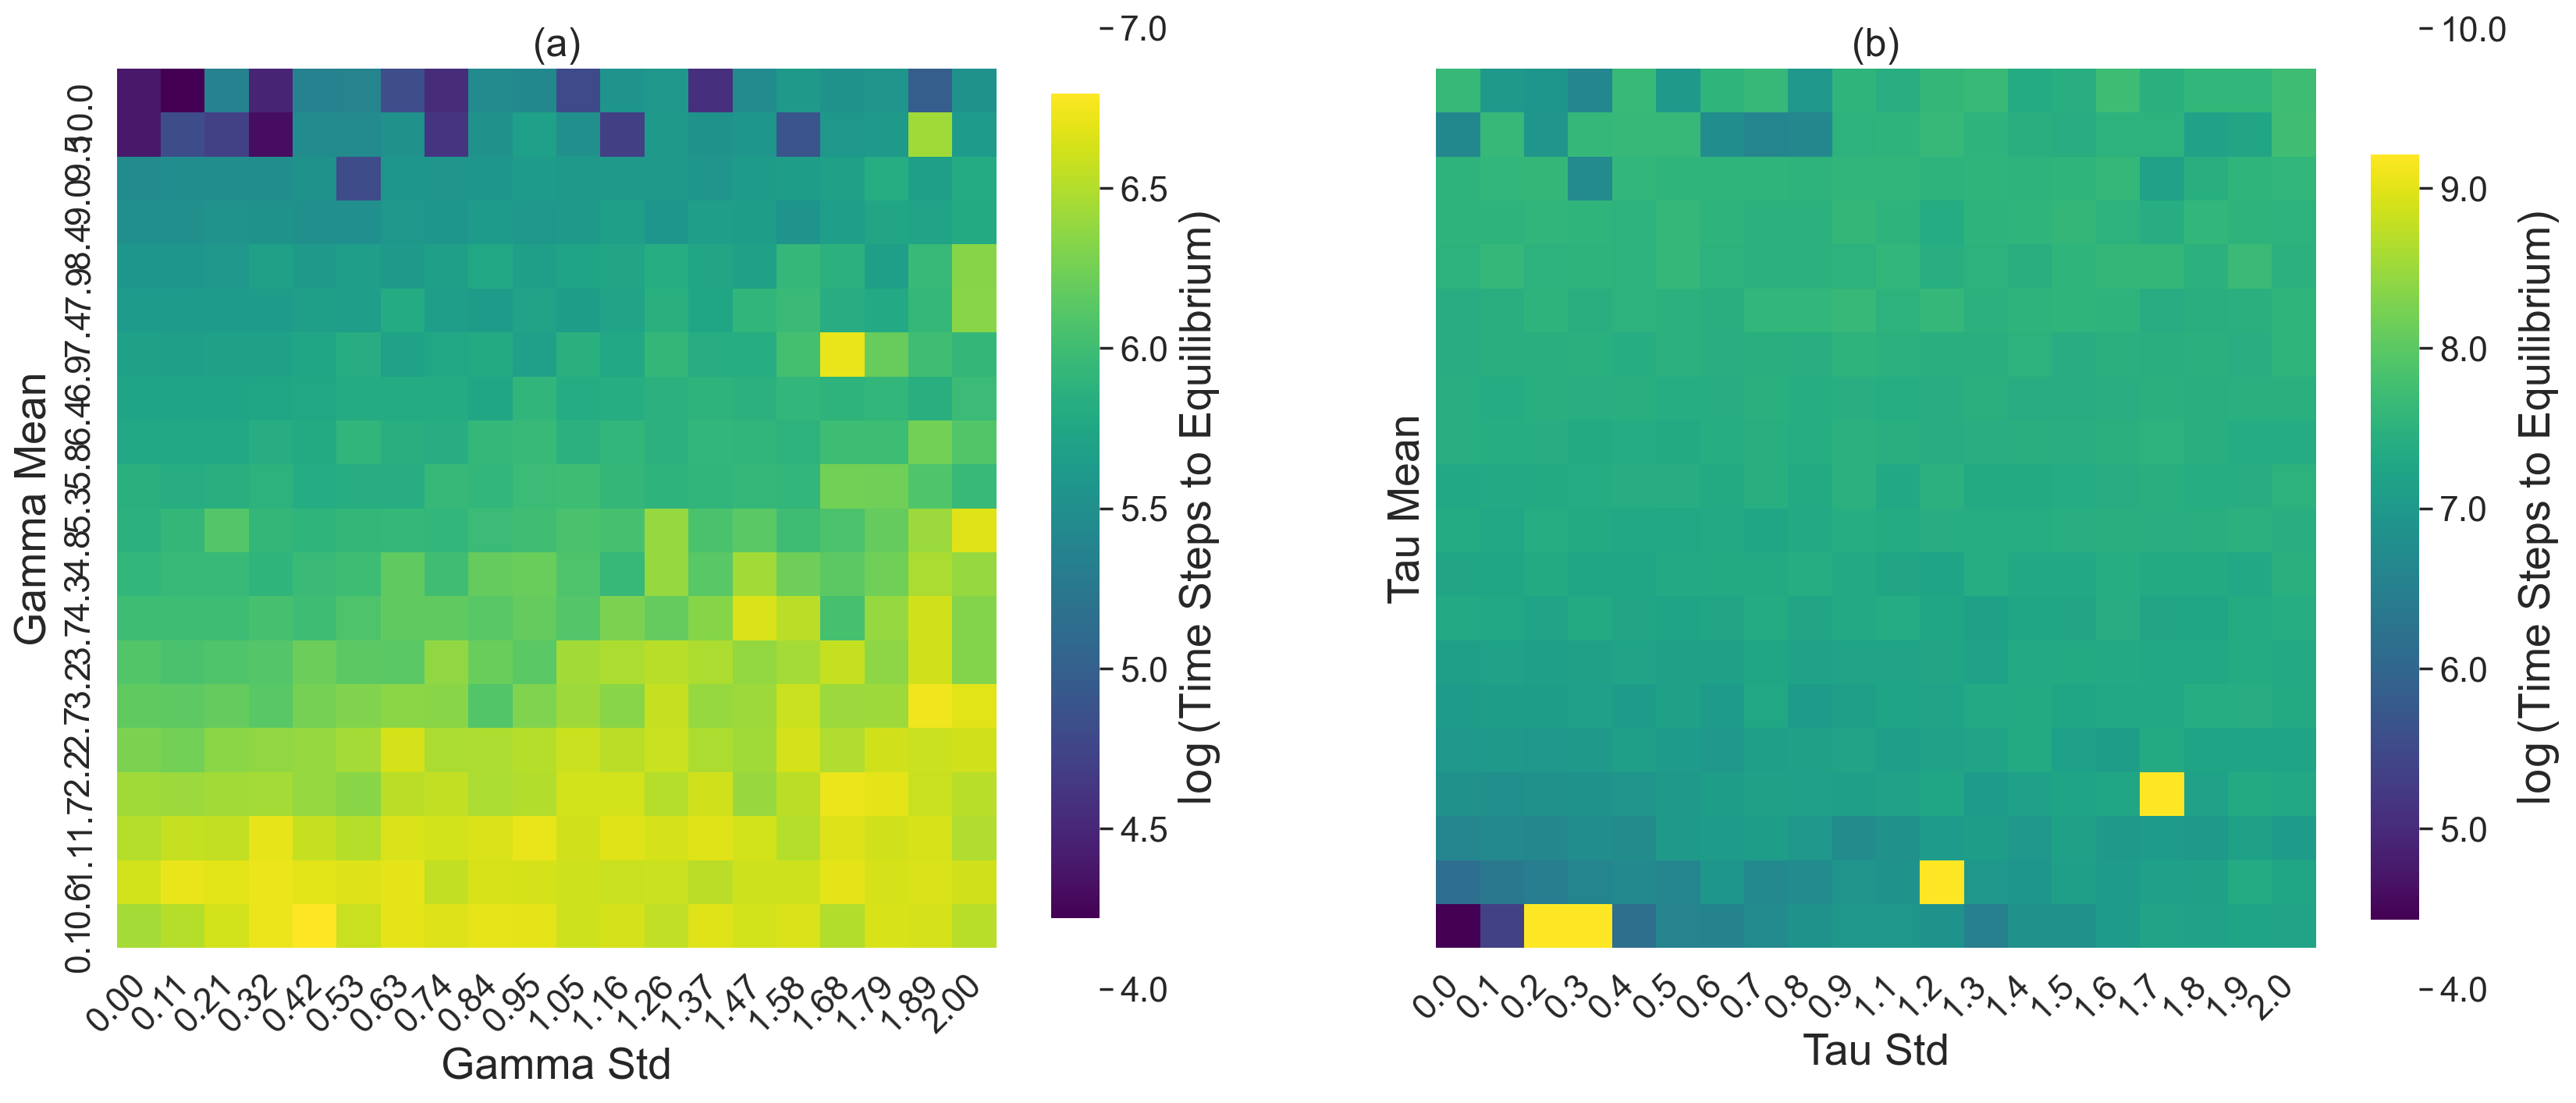

In [76]:

plot_heatmaps(convergence_rates_gamma, convergence_rates_tau, gamma_mean_values, gamma_std_values, tau_mean_values, tau_std_values)
